# Buckling Strength ML — Standalone Notebook

This notebook is a standalone, Colab-friendly workflow that cleans the dataset, defines the modeling target, validates structural missingness, aggregates duplicates by geometry, runs grouped evaluation, trains model families, and saves artifacts + plots.

**Colab note:** upload `data.xlsx` and set `DATA_PATH = Path("/content/data.xlsx")` in the setup cell if needed.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

SHEET_NAME = "Swati (Beam with hole)"

# Data path detection (project root or Colab)
BASE = Path.cwd()
DATA_PATH_CANDIDATES = [
    BASE / "data/raw/data.xlsx",
    BASE / "data/data.xlsx",
    BASE / "data.xlsx",
    Path("/content/data.xlsx"),
]
DATA_PATH = next((p for p in DATA_PATH_CANDIDATES if p.exists()), None)
if DATA_PATH is None:
    raise FileNotFoundError(
        "Could not find data.xlsx. Place it at data/raw/data.xlsx or /content/data.xlsx (Colab)."
    )

# Output dirs
(Path("outputs/figures")).mkdir(parents=True, exist_ok=True)
(Path("outputs/tables")).mkdir(parents=True, exist_ok=True)
(Path("outputs/models")).mkdir(parents=True, exist_ok=True)
(Path("data/interim")).mkdir(parents=True, exist_ok=True)

print(f"Using DATA_PATH: {DATA_PATH}")

Using DATA_PATH: /Users/sauravkrishna/Documents/Python_stuffs/ML_project/data/data.xlsx


## Phase 0 — Load + sanity
Strip column names and drop the units row.

In [2]:
# Load and sanitize
_df_raw = pd.read_excel(DATA_PATH, sheet_name=SHEET_NAME)
raw_cols = list(_df_raw.columns)

_df = _df_raw.copy()
_df.columns = [c.strip() for c in raw_cols]

# Drop units row
if "SL. No" in _df.columns:
    units_mask = _df["SL. No"].astype(str).str.strip().eq("Units")
    _df = _df.loc[~units_mask].copy()
    units_rows = int(units_mask.sum())
else:
    units_rows = 0

print("Raw shape:", _df_raw.shape)
print("Units rows removed:", units_rows)
print("Post-drop shape:", _df.shape)
print("Columns:", _df.columns.tolist())

# Missingness snapshot
missing_pct = (_df.isna().mean() * 100).sort_values(ascending=False)
print("Top-10 missingness columns (%):")
print(missing_pct.head(10))

df = _df.copy()

Raw shape: (494, 33)
Units rows removed: 1
Post-drop shape: (493, 33)
Columns: ['SL. No', 'JOURNAL TITLE', 'SPECIMEN', 'SHAPE CODE', 'Boundary condition', 'Loading condition', 'Fy', 'Fu', 'E', 'ν', 't', 'L', 'bw', 'bf1', 'bf2', 'bl1', 'bl2', 'q', 'r', 'HOLE SHAPE', 'l hole', 'h hole', 'r hole', 'Number Of Holes in Channel', 'Distance from top to centre of first hole Y', 'Distance from left  to centre of first hole X', 'Centre to centre distance between adjesent holes in X direction  Sx', 'Ultimate  Buckiling Strength (Mtest)', 'Ultimate  Buckiling Strength (MFEM)', 'Failure Mode', 'AISI', 'Eurocode 3', 'AS/NZS']
Top-10 missingness columns (%):
AS/NZS                                                                 100.000000
Eurocode 3                                                             100.000000
Ultimate  Buckiling Strength (Mtest)                                    70.182556
q                                                                       67.342799
AISI                

## Phase 1 — Target construction + QC
Fill Mtest from MFEM, coerce numeric, drop invalid targets.

In [3]:
MTEST_COL = "Ultimate  Buckiling Strength (Mtest)"
MFEM_COL = "Ultimate  Buckiling Strength (MFEM)"

mtest = df[MTEST_COL]
mfem = df[MFEM_COL]

y_from_fem = mtest.isna() & mfem.notna()
y_filled = mtest.fillna(mfem)
y = pd.to_numeric(y_filled, errors="coerce")

rows_before = len(df)
rows_after = int(y.notna().sum())
rows_dropped = rows_before - rows_after

fill_count = int(y_from_fem.sum())
non_numeric_count = int(y_filled.notna().sum() - y.notna().sum())

# Apply
df = df.loc[y.notna()].copy()
df["y"] = y.loc[y.notna()].astype(float)
df["y_from_fem"] = y_from_fem.loc[y.notna()]

missing_rates = pd.Series({
    "Mtest_missing_pct": mtest.isna().mean() * 100,
    "MFEM_missing_pct": mfem.isna().mean() * 100,
    "filled_missing_pct": y_filled.isna().mean() * 100,
})

print("Rows before:", rows_before)
print("Rows after:", rows_after)
print("Rows dropped (non-numeric target):", rows_dropped)
print("Filled from MFEM:", fill_count)
print("Non-numeric targets after fill:", non_numeric_count)
print("Missingness rates (%):")
print(missing_rates.round(3))

Rows before: 493
Rows after: 492
Rows dropped (non-numeric target): 1
Filled from MFEM: 346
Non-numeric targets after fill: 1
Missingness rates (%):
Mtest_missing_pct     70.183
MFEM_missing_pct      17.039
filled_missing_pct     0.000
dtype: float64


## Phase 2 — Feature set definition + pruning
Drop excluded columns by name, keep journal/specimen only as metadata.

In [4]:
META_COLS = ["JOURNAL TITLE", "SPECIMEN"]
DROP_COLS = [
    "SL. No", "SHAPE CODE", "Boundary condition", "Loading condition",
    "Failure Mode", "AISI", "Eurocode 3", "AS/NZS", "q",
    MTEST_COL, MFEM_COL, "y", "y_from_fem",
]

# Remove non-features and meta from X_full
X_full = df.drop(columns=[c for c in DROP_COLS + META_COLS if c in df.columns]).copy()
meta = df[META_COLS].copy() if all(c in df.columns for c in META_COLS) else pd.DataFrame()

# Drop constants
nunique = X_full.nunique(dropna=True)
constant_cols = nunique[nunique <= 1].index.tolist()
X_full = X_full.drop(columns=constant_cols)
feature_cols = X_full.columns.tolist()

# Numeric vs categorical

def is_numeric_col(s, threshold=0.9):
    if pd.api.types.is_numeric_dtype(s):
        return True
    s_non_null = s.dropna()
    if s_non_null.empty:
        return False
    converted = pd.to_numeric(s_non_null, errors="coerce")
    return converted.notna().mean() >= threshold

numeric_cols = [c for c in feature_cols if is_numeric_col(X_full[c])]
categorical_cols = [c for c in feature_cols if c not in numeric_cols]

print("Dropped columns:", [c for c in DROP_COLS if c in df.columns])
print("Meta columns:", [c for c in META_COLS if c in df.columns])
print("Constant columns dropped:", constant_cols)
print(f"Final feature columns (n={len(feature_cols)}):")
print(feature_cols)
print("Numeric features:", len(numeric_cols))
print("Categorical features:", len(categorical_cols))

Dropped columns: ['SL. No', 'SHAPE CODE', 'Boundary condition', 'Loading condition', 'Failure Mode', 'AISI', 'Eurocode 3', 'AS/NZS', 'q', 'Ultimate  Buckiling Strength (Mtest)', 'Ultimate  Buckiling Strength (MFEM)', 'y', 'y_from_fem']
Meta columns: ['JOURNAL TITLE', 'SPECIMEN']
Constant columns dropped: ['ν']
Final feature columns (n=19):
['Fy', 'Fu', 'E', 't', 'L', 'bw', 'bf1', 'bf2', 'bl1', 'bl2', 'r', 'HOLE SHAPE', 'l hole', 'h hole', 'r hole', 'Number Of Holes in Channel', 'Distance from top to centre of first hole Y', 'Distance from left  to centre of first hole X', 'Centre to centre distance between adjesent holes in X direction  Sx']
Numeric features: 18
Categorical features: 1


## Phase 2.5 — Diagnostics (E and hole count)
Check whether `E` and hole count behave as expected.

In [5]:
E_col = "E"
holes_col = "Number Of Holes in Channel"
sx_col = "Centre to centre distance between adjesent holes in X direction  Sx"
shape_col = "HOLE SHAPE"

E_num = pd.to_numeric(df[E_col], errors="coerce")
holes_num = pd.to_numeric(df[holes_col], errors="coerce")

print("E non-numeric count:", int(df[E_col].notna().sum() - E_num.notna().sum()))
print("E unique (numeric):", int(E_num.nunique(dropna=True)))
print("E top values:")
print(E_num.value_counts(dropna=True).head(10))

per_journal = df.assign(E_num=E_num).groupby("JOURNAL TITLE")["E_num"].nunique().sort_values(ascending=False)
print("Journals with multiple E values (top 10):")
print(per_journal.head(10))
print("Count of journals with >1 E:", int((per_journal > 1).sum()))

print("Number Of Holes distribution:")
print(holes_num.value_counts(dropna=False).sort_index())

sx_present_for_single = df.loc[holes_num <= 1, sx_col].notna().sum()
print("Sx present when holes <= 1:", int(sx_present_for_single))

print("HOLE SHAPE distribution:")
print(df[shape_col].value_counts(dropna=False).head(10))

E non-numeric count: 0
E unique (numeric): 7
E top values:
E
200000    282
206000     88
202800     84
203500     18
203000      9
208000      8
196000      3
Name: count, dtype: int64
Journals with multiple E values (top 10):
JOURNAL TITLE
 Chen et al.,2020            1
Chandramohan et al., 2025    1
Moen et al. 2013             1
Oruç 1 2025                  1
Sadid et al., 2025           1
Sivakumaran et al., 2006     1
Soroori Rad 2010             1
Soroori Rad 2011             1
Tohamy et al., 2021          1
Zhao et al., 2019            1
Name: E_num, dtype: int64
Count of journals with >1 E: 0
Number Of Holes distribution:
Number Of Holes in Channel
1.0    206
2.0     11
3.0    227
4.0      4
5.0      7
8.0      3
NaN     34
Name: count, dtype: int64
Sx present when holes <= 1: 5
HOLE SHAPE distribution:
HOLE SHAPE
Elongated    204
Rectangle    115
Square       105
no hole       30
circle        17
Circle        11
No hole        4
square         3
rectangle      3
Name: count, 

## Phase 3 — Structural missingness validation + fixes
Normalize HOLE SHAPE, report missingness patterns, flag inconsistencies, then apply minimal fixes.

In [6]:
# Normalize HOLE SHAPE
shape_before = df[shape_col].value_counts(dropna=False)
shape_norm = (
    df[shape_col]
      .astype(str)
      .str.strip()
      .str.lower()
      .str.replace(r"\s+", " ", regex=True)
)
shape_norm = shape_norm.replace("nan", np.nan)
shape_norm = shape_norm.replace({"no hole": "no_hole", "no_hole": "no_hole"})
shape_norm = shape_norm.replace({
    "circle": "circle",
    "square": "square",
    "rectangle": "rectangle",
    "elongated": "elongated",
})
canonical_shapes = {"circle", "square", "rectangle", "elongated", "no_hole"}
unknown_shapes = sorted(set(shape_norm.dropna().unique()) - canonical_shapes)

df[shape_col] = shape_norm
shape_after = df[shape_col].value_counts(dropna=False)

print("HOLE SHAPE before normalization:")
print(shape_before)
print("\n")
print("HOLE SHAPE after normalization:")
print(shape_after)
print("\n")
print("Unknown shapes:", unknown_shapes)

# Conditional missingness tables
hole_cols = [
    "l hole", "h hole", "r hole",
    holes_col,
    "Distance from top to centre of first hole Y",
    "Distance from left  to centre of first hole X",
    sx_col,
]

shape_missing = (
    df.groupby(shape_col, dropna=False)[hole_cols]
      .apply(lambda g: g.isna().mean() * 100)
)
shape_counts = df.groupby(shape_col, dropna=False).size().rename("n")
shape_table = shape_missing.join(shape_counts)

holes_num = pd.to_numeric(df[holes_col], errors="coerce")
by_holes = (
    df.assign(_holes_num=holes_num)
      .groupby("_holes_num", dropna=False)[hole_cols]
      .apply(lambda g: g.isna().mean() * 100)
)
by_holes_counts = (
    df.assign(_holes_num=holes_num)
      .groupby("_holes_num", dropna=False)
      .size().rename("n")
)
by_holes_table = by_holes.join(by_holes_counts)

print("\n")
print("Missingness by HOLE SHAPE (%):")
print(shape_table.round(1))
print("\n")
print("Missingness by Number Of Holes (%):")
print(by_holes_table.round(1))

# Flags
no_hole_mask = df[shape_col].eq("no_hole")
no_hole_any_present = df.loc[no_hole_mask, hole_cols].notna().any(axis=1)

df["inconsistent_no_hole_metadata"] = False
df.loc[no_hole_mask, "inconsistent_no_hole_metadata"] = no_hole_any_present

df["inconsistent_sx_for_single_hole"] = (holes_num <= 1) & df[sx_col].notna()

print("\n")
print("Flag counts:")
print("inconsistent_no_hole_metadata:", int(df["inconsistent_no_hole_metadata"].sum()))
print("inconsistent_sx_for_single_hole:", int(df["inconsistent_sx_for_single_hole"].sum()))

HOLE SHAPE before normalization:
HOLE SHAPE
Elongated    204
Rectangle    115
Square       105
no hole       30
circle        17
Circle        11
No hole        4
square         3
rectangle      3
Name: count, dtype: int64


HOLE SHAPE after normalization:
HOLE SHAPE
elongated    204
rectangle    118
square       108
no_hole       34
circle        28
Name: count, dtype: int64


Unknown shapes: []


Missingness by HOLE SHAPE (%):
            l hole  h hole  r hole  Number Of Holes in Channel  \
HOLE SHAPE                                                       
circle       100.0   100.0     0.0                         0.0   
elongated      0.0     0.0     0.0                         0.0   
no_hole      100.0   100.0   100.0                       100.0   
rectangle      0.0     0.0   100.0                         0.0   
square         0.0     0.0   100.0                         0.0   

            Distance from top to centre of first hole Y  \
HOLE SHAPE                                   

In [7]:
# Apply minimal fixes + validate
no_hole_mask = df[shape_col].eq("no_hole")

# Fix: remove Y distance for no_hole
fix_y_col = "Distance from top to centre of first hole Y"
df.loc[no_hole_mask, fix_y_col] = np.nan

# Fix: remove Sx where holes <= 1
holes_num = pd.to_numeric(df[holes_col], errors="coerce")
df.loc[holes_num <= 1, sx_col] = np.nan

# Recompute flags
no_hole_any_present = df.loc[no_hole_mask, hole_cols].notna().any(axis=1)
df["inconsistent_no_hole_metadata"] = False
df.loc[no_hole_mask, "inconsistent_no_hole_metadata"] = no_hole_any_present

df["inconsistent_sx_for_single_hole"] = (holes_num <= 1) & df[sx_col].notna()

print("Post-fix inconsistent_no_hole_metadata:", int(df["inconsistent_no_hole_metadata"].sum()))
print("Post-fix inconsistent_sx_for_single_hole:", int(df["inconsistent_sx_for_single_hole"].sum()))

Post-fix inconsistent_no_hole_metadata: 0
Post-fix inconsistent_sx_for_single_hole: 0


## Phase 4 — Geometry signature + duplicates + aggregation
Create a stable geometry hash and aggregate duplicates within journal.

In [8]:
import hashlib

# Signature uses feature values only (with NA sentinel)
SENTINEL = "__MISSING__"
X_sig = df[feature_cols].copy()

for c in numeric_cols:
    X_sig[c] = pd.to_numeric(X_sig[c], errors="coerce")
for c in categorical_cols:
    X_sig[c] = X_sig[c].astype(str).str.strip().str.lower()
    X_sig.loc[X_sig[c] == "nan", c] = np.nan

X_sig = X_sig.where(X_sig.notna(), SENTINEL)
row_strings = X_sig.astype(str).apply(lambda r: "|".join(r.values.tolist()), axis=1)
geom_sig = row_strings.apply(lambda s: hashlib.md5(s.encode("utf-8")).hexdigest())

df["geometry_signature"] = geom_sig

# Duplicates within journal
key_cols = ["JOURNAL TITLE", "geometry_signature"]
group_sizes = df.groupby(key_cols).size()

df_agg = (
    df.groupby(key_cols, as_index=False)
      .agg(
          **{c: (c, "first") for c in feature_cols},
          target_mean=("y", "mean"),
          target_std=("y", "std"),
          replicate_count=("y", "size"),
      )
)

print("Rows before aggregation:", len(df))
print("Unique groups:", int(group_sizes.shape[0]))
print("Duplicate groups (>1):", int((group_sizes > 1).sum()))
print("Rows after aggregation:", len(df_agg))
print("Sum replicate_count:", int(df_agg["replicate_count"].sum()))

# Save duplicate logs
dup_summary = (
    df.groupby(key_cols)
      .agg(
          replicate_count=("y", "size"),
          target_mean=("y", "mean"),
          target_std=("y", "std"),
      )
      .reset_index()
)

dup_rows = df[["SL. No", "SPECIMEN"] + key_cols + ["y", "y_from_fem"]].merge(
    dup_summary[key_cols + ["replicate_count"]], on=key_cols, how="left"
)

Path("outputs/tables").mkdir(parents=True, exist_ok=True)
dup_summary.to_csv("outputs/tables/duplicates_summary.csv", index=False)
dup_rows.to_csv("outputs/tables/duplicates_rows.csv", index=False)

Rows before aggregation: 492
Unique groups: 331
Duplicate groups (>1): 54
Rows after aggregation: 331
Sum replicate_count: 492


## Phase 5 — Pre-model EDA
Generate required pre-model plots and save to `outputs/figures/`.

In [9]:
# Plot helpers
sns.set_theme(style="whitegrid", context="notebook")

FIG_DIR = Path("outputs/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

def savefig(name):
    path = FIG_DIR / f"{name}.png"
    plt.savefig(path, dpi=150, bbox_inches="tight")
    print("Saved:", path)

/var/folders/2r/65b3v1496498f35zwrwmt7900000gn/T/ipykernel_77715/3806035838.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Saved: outputs/figures/missingness_top20.png


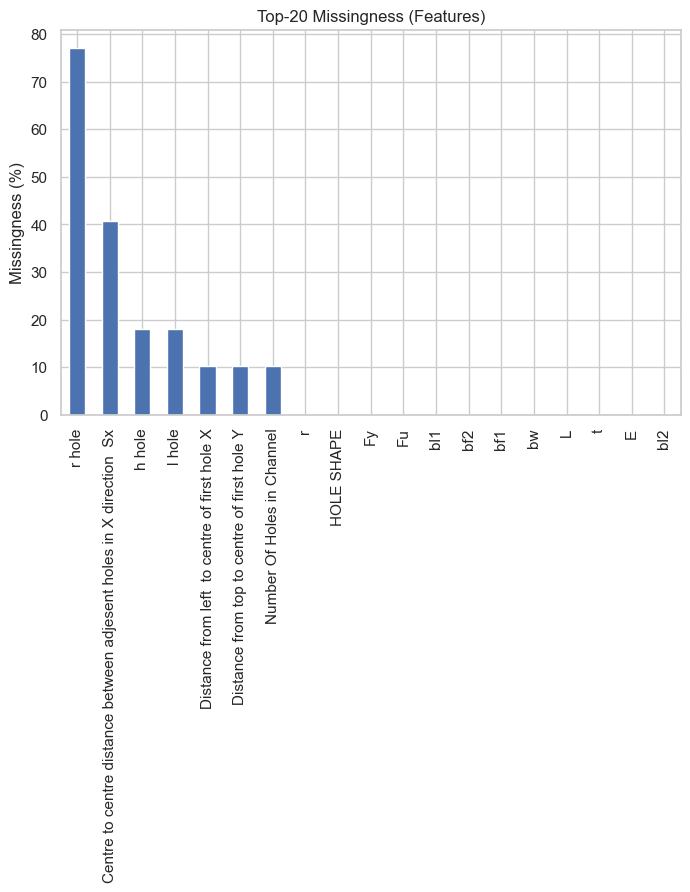

In [10]:
# Missingness % bar chart (features only)
missing_pct = df_agg[feature_cols].isna().mean().sort_values(ascending=False) * 100

plt.figure(figsize=(8, 5))
missing_pct.head(20).plot(kind="bar")
plt.ylabel("Missingness (%)")
plt.title("Top-20 Missingness (Features)")
plt.tight_layout()
savefig("missingness_top20")
plt.show()

Saved: outputs/figures/missingness_by_hole_shape.png


/var/folders/2r/65b3v1496498f35zwrwmt7900000gn/T/ipykernel_77715/3265491332.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


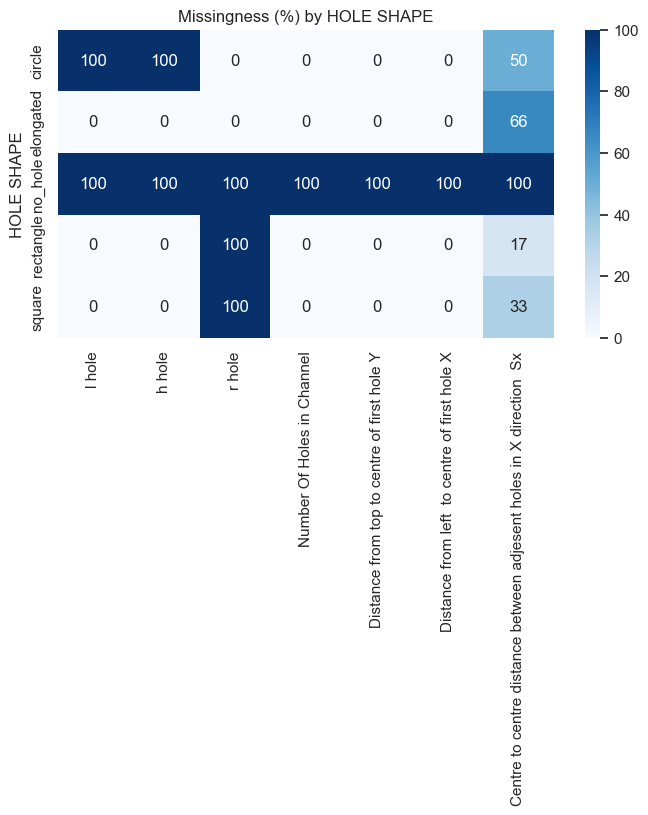

In [11]:
# Conditional missingness by HOLE SHAPE (aggregated)
missing_by_shape = (
    df_agg.groupby(shape_col)[hole_cols]
          .apply(lambda g: g.isna().mean() * 100)
          .sort_index()
)

plt.figure(figsize=(8, 4))
sns.heatmap(missing_by_shape, annot=True, fmt=".0f", cmap="Blues")
plt.title("Missingness (%) by HOLE SHAPE")
plt.ylabel("HOLE SHAPE")
plt.tight_layout()
savefig("missingness_by_hole_shape")
plt.show()

Saved: outputs/figures/sx_missing_by_holes.png


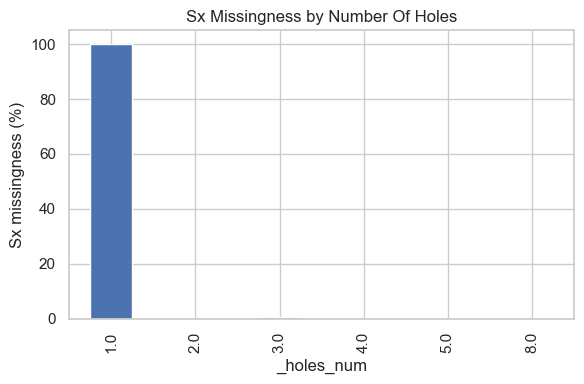

In [12]:
# Sx missingness by Number Of Holes
holes_num = pd.to_numeric(df_agg[holes_col], errors="coerce")

sx_missing_by_holes = (
    df_agg.assign(_holes_num=holes_num)
          .groupby("_holes_num")[sx_col]
          .apply(lambda s: s.isna().mean() * 100)
)

plt.figure(figsize=(6, 4))
sx_missing_by_holes.plot(kind="bar")
plt.ylabel("Sx missingness (%)")
plt.title("Sx Missingness by Number Of Holes")
plt.tight_layout()
savefig("sx_missing_by_holes")
plt.show()

Saved: outputs/figures/target_hist.png


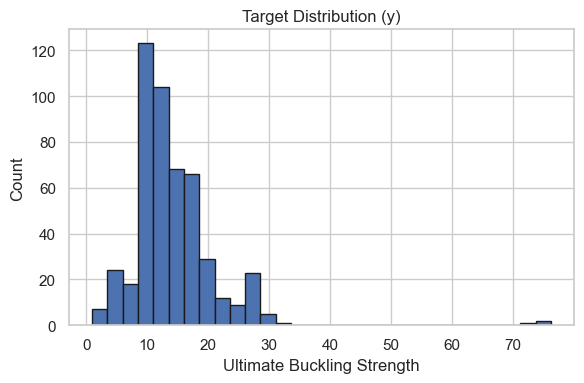

Saved: outputs/figures/target_box.png


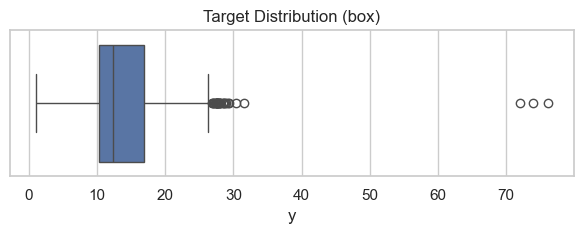

Saved: outputs/figures/target_by_y_from_fem.png


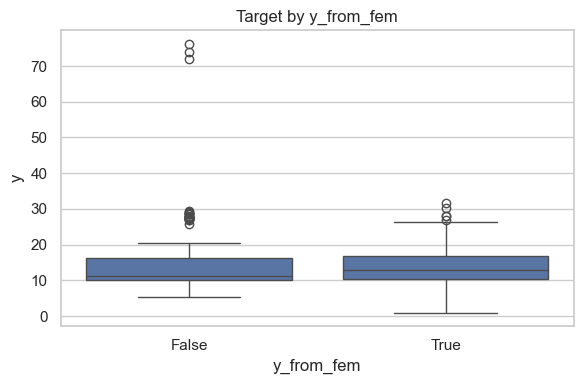

In [13]:
# Target distribution (row-level) + y_from_fem split
plt.figure(figsize=(6, 4))
plt.hist(df["y"], bins=30, edgecolor="k")
plt.title("Target Distribution (y)")
plt.xlabel("Ultimate Buckling Strength")
plt.ylabel("Count")
plt.tight_layout()
savefig("target_hist")
plt.show()

plt.figure(figsize=(6, 2.5))
sns.boxplot(x=df["y"])
plt.title("Target Distribution (box)")
plt.tight_layout()
savefig("target_box")
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x="y_from_fem", y="y")
plt.title("Target by y_from_fem")
plt.tight_layout()
savefig("target_by_y_from_fem")
plt.show()

Saved: outputs/figures/target_by_hole_shape.png


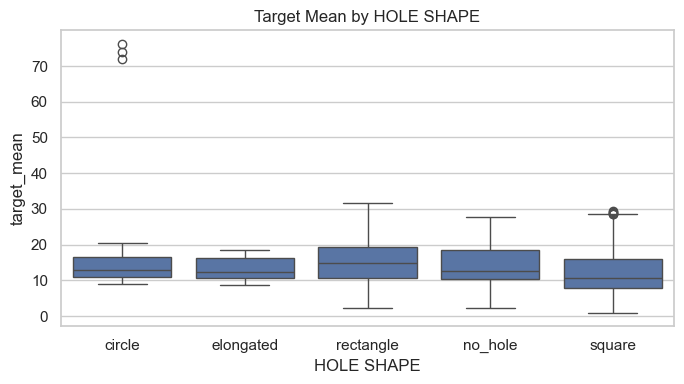

In [14]:
# Target vs HOLE SHAPE (aggregated)
plt.figure(figsize=(7, 4))
sns.boxplot(data=df_agg, x=shape_col, y="target_mean")
plt.title("Target Mean by HOLE SHAPE")
plt.tight_layout()
savefig("target_by_hole_shape")
plt.show()

In [15]:
# Scatter: top numeric features vs target_mean (features only)
num_feats = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df_agg[c])]

corr = df_agg[num_feats + ["target_mean"]].corr()["target_mean"].abs().sort_values(ascending=False)
top_feats = [c for c in corr.index if c != "target_mean"][:6]

for c in top_feats:
    plt.figure(figsize=(5, 4))
    sns.scatterplot(data=df_agg, x=c, y="target_mean", alpha=0.7)
    plt.title(f"target_mean vs {c}")
    plt.tight_layout()
    savefig(f"scatter_target_vs_{c}")
    plt.show()

Saved: outputs/figures/replicate_count_dist.png


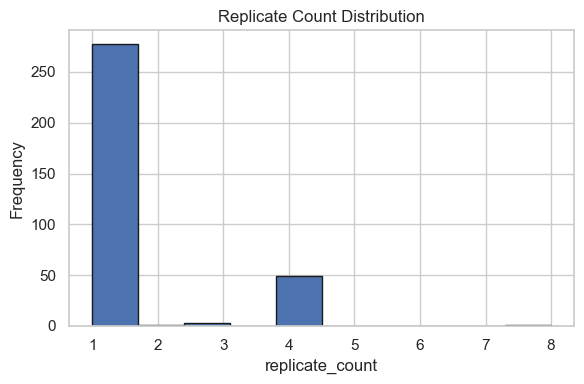

Saved: outputs/figures/target_std_vs_mean.png


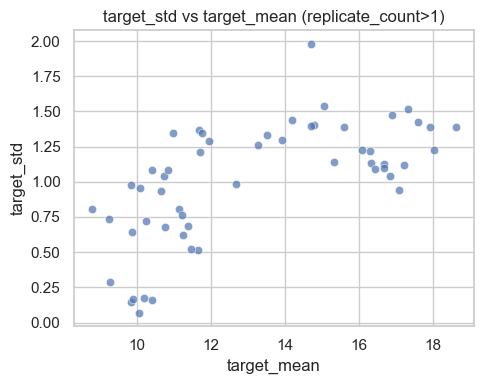

In [16]:
# Replicate diagnostics
plt.figure(figsize=(6, 4))
df_agg["replicate_count"].plot(kind="hist", bins=10, edgecolor="k")
plt.title("Replicate Count Distribution")
plt.xlabel("replicate_count")
plt.tight_layout()
savefig("replicate_count_dist")
plt.show()

rep_gt1 = df_agg[df_agg["replicate_count"] > 1]
plt.figure(figsize=(5, 4))
sns.scatterplot(data=rep_gt1, x="target_mean", y="target_std", alpha=0.7)
plt.title("target_std vs target_mean (replicate_count>1)")
plt.tight_layout()
savefig("target_std_vs_mean")
plt.show()

Saved: outputs/figures/rows_per_journal.png


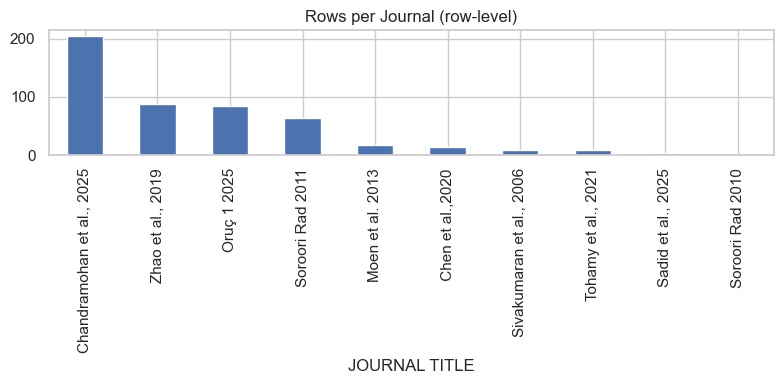

Saved: outputs/figures/target_by_journal.png


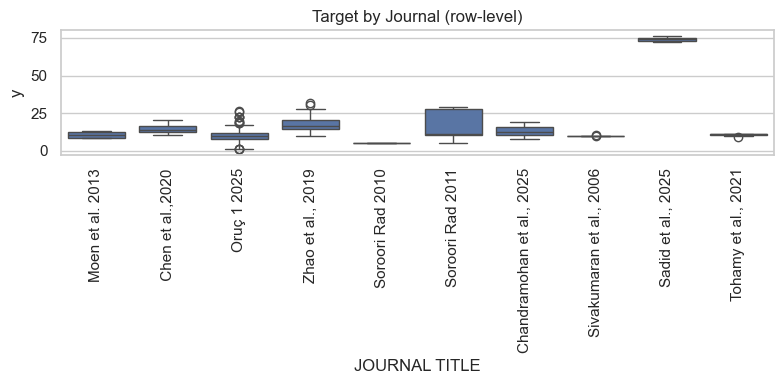

Saved: outputs/figures/hole_shape_mix_by_journal.png


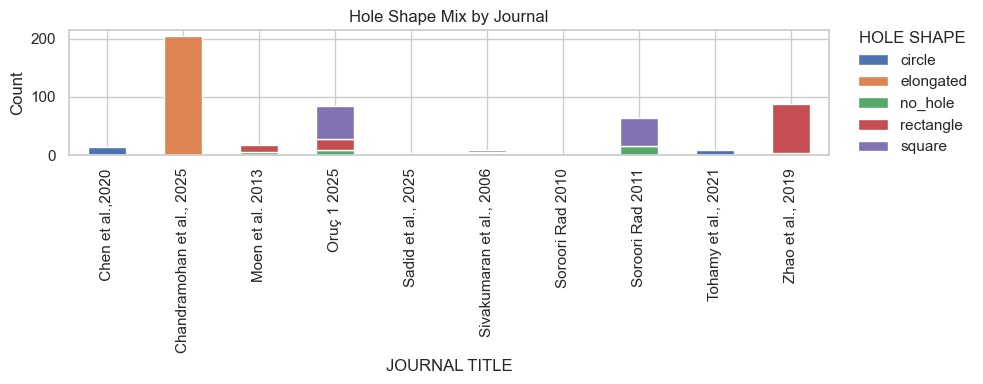

In [17]:
# Metadata diagnostics (row-level)
plt.figure(figsize=(8, 4))
df["JOURNAL TITLE"].value_counts().plot(kind="bar")
plt.title("Rows per Journal (row-level)")
plt.tight_layout()
savefig("rows_per_journal")
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x="JOURNAL TITLE", y="y")
plt.title("Target by Journal (row-level)")
plt.xticks(rotation=90)
plt.tight_layout()
savefig("target_by_journal")
plt.show()

ct = pd.crosstab(df["JOURNAL TITLE"], df[shape_col])
ax = ct.plot(kind="bar", stacked=True, figsize=(10, 4))
ax.set_title("Hole Shape Mix by Journal")
ax.set_xlabel("JOURNAL TITLE")
ax.set_ylabel("Count")
ax.tick_params(axis="x", rotation=90)
ax.legend(title="HOLE SHAPE", loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)
plt.tight_layout()
savefig("hole_shape_mix_by_journal")
plt.show()

hole_shape_table = ct.copy()
hole_shape_table["total"] = hole_shape_table.sum(axis=1)
hole_shape_table = hole_shape_table.sort_values("total", ascending=False)
hole_shape_table.to_csv("outputs/tables/hole_shape_by_journal.csv", index=True)

## Phase 6 — Grouped holdout + GroupKFold
Split by geometry_signature to avoid leakage.

In [18]:
from sklearn.model_selection import GroupShuffleSplit, GroupKFold

X_model = df_agg[feature_cols].copy()
y_model = df_agg["target_mean"].copy()
groups = df_agg["geometry_signature"].copy()

# Grouped holdout
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
train_idx, test_idx = next(gss.split(X_model, y_model, groups=groups))

df_train = df_agg.iloc[train_idx].copy()
df_test = df_agg.iloc[test_idx].copy()

print("train rows:", len(df_train), "test rows:", len(df_test))
print("train groups:", df_train["geometry_signature"].nunique(),
      "test groups:", df_test["geometry_signature"].nunique())

group_overlap = set(df_train["geometry_signature"]).intersection(set(df_test["geometry_signature"]))
print("group overlap (should be 0):", len(group_overlap))

# GroupKFold on train
X_train = df_train[feature_cols].copy()
y_train = df_train["target_mean"].copy()
groups_train = df_train["geometry_signature"].copy()

gkf = GroupKFold(n_splits=5)
cv_splits = list(gkf.split(X_train, y_train, groups=groups_train))

for i, (tr_idx, val_idx) in enumerate(cv_splits, start=1):
    tr_groups = set(groups_train.iloc[tr_idx])
    val_groups = set(groups_train.iloc[val_idx])
    overlap = tr_groups.intersection(val_groups)
    print(f"Fold {i}: train_rows={len(tr_idx)} val_rows={len(val_idx)} overlap_groups={len(overlap)}")

train rows: 264 test rows: 67
train groups: 264 test groups: 67
group overlap (should be 0): 0
Fold 1: train_rows=211 val_rows=53 overlap_groups=0
Fold 2: train_rows=211 val_rows=53 overlap_groups=0
Fold 3: train_rows=211 val_rows=53 overlap_groups=0
Fold 4: train_rows=211 val_rows=53 overlap_groups=0
Fold 5: train_rows=212 val_rows=52 overlap_groups=0


## Phase 7 — Preprocessing pipelines + smoke test
Define preprocessing for linear/tree models and run a single-fold smoke test.

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Treat Number Of Holes as categorical for linear models
holes_col = "Number Of Holes in Channel"
linear_categorical_cols = list(set(categorical_cols + ([holes_col] if holes_col in feature_cols else [])))
linear_numeric_cols = [c for c in numeric_cols if c not in linear_categorical_cols]

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocess_linear = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), linear_numeric_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", ohe)
        ]), linear_categorical_cols),
    ],
    remainder="drop"
)

preprocess_tree = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median"))
        ]), numeric_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", ohe)
        ]), categorical_cols),
    ],
    remainder="drop"
)

# Smoke test
(tr_idx, val_idx) = cv_splits[0]

X_tr = X_train.iloc[tr_idx]
y_tr = y_train.iloc[tr_idx]
X_val = X_train.iloc[val_idx]
y_val = y_train.iloc[val_idx]

# Linear
pipe_linear = Pipeline([("prep", preprocess_linear), ("model", Ridge(alpha=1.0, random_state=RANDOM_SEED))])
pipe_linear.fit(X_tr, y_tr)
pred_linear = pipe_linear.predict(X_val)

# Tree
pipe_tree = Pipeline([
    ("prep", preprocess_tree),
    ("model", RandomForestRegressor(n_estimators=200, random_state=RANDOM_SEED, n_jobs=-1))
])
pipe_tree.fit(X_tr, y_tr)
pred_tree = pipe_tree.predict(X_val)

mae_linear = mean_absolute_error(y_val, pred_linear)
mae_tree = mean_absolute_error(y_val, pred_tree)

corr_linear = np.corrcoef(y_val, pred_linear)[0, 1]
corr_tree = np.corrcoef(y_val, pred_tree)[0, 1]

print(f"[Linear smoke] MAE={mae_linear:.3f} | Pearson={corr_linear:.3f} | n_val={len(y_val)}")
print(f"[Tree smoke] MAE={mae_tree:.3f} | Pearson={corr_tree:.3f} | n_val={len(y_val)}")

[Linear smoke] MAE=1.090 | Pearson=0.991 | n_val=53
[Tree smoke] MAE=1.130 | Pearson=0.989 | n_val=53


## Phase 8 — Model training (small grids) + results table
Train linear/tree families with small grids and record OOF + holdout metrics.

In [20]:
from sklearn.base import clone
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from itertools import product

X_test = df_test[feature_cols].copy()
y_test = df_test["target_mean"].copy()

# CV splits from Phase 6

def pearson_corr(y_true, y_pred):
    if len(y_true) < 2:
        return np.nan
    return np.corrcoef(y_true, y_pred)[0, 1]


def param_grid(grid_dict):
    keys = list(grid_dict.keys())
    for values in product(*grid_dict.values()):
        yield dict(zip(keys, values))


def oof_predict(pipeline, X, y, splits):
    oof = np.full(len(y), np.nan, dtype=float)
    for tr_idx, val_idx in splits:
        model = clone(pipeline)
        model.fit(X.iloc[tr_idx], y.iloc[tr_idx])
        oof[val_idx] = model.predict(X.iloc[val_idx])
    return oof

model_specs = [
    {
        "name": "Ridge",
        "family": "linear",
        "estimator": Ridge(),
        "params": {"model__alpha": [0.1, 1.0, 10.0]},
        "preprocess": preprocess_linear,
    },
    {
        "name": "Lasso",
        "family": "linear",
        "estimator": Lasso(max_iter=10000),
        "params": {"model__alpha": [0.001, 0.01, 0.1]},
        "preprocess": preprocess_linear,
    },
    {
        "name": "ElasticNet",
        "family": "linear",
        "estimator": ElasticNet(max_iter=10000),
        "params": {"model__alpha": [0.01, 0.1], "model__l1_ratio": [0.2, 0.5, 0.8]},
        "preprocess": preprocess_linear,
    },
    {
        "name": "RandomForest",
        "family": "tree",
        "estimator": RandomForestRegressor(
            n_estimators=300,
            random_state=RANDOM_SEED,
            n_jobs=-1,
        ),
        "params": {"model__max_depth": [None, 10], "model__min_samples_leaf": [1, 3]},
        "preprocess": preprocess_tree,
    },
    {
        "name": "HistGradientBoosting",
        "family": "tree",
        "estimator": HistGradientBoostingRegressor(
            random_state=RANDOM_SEED,
            max_iter=300,
        ),
        "params": {
            "model__learning_rate": [0.05, 0.1],
            "model__max_depth": [3, None],
            "model__l2_regularization": [0.0, 0.1],
        },
        "preprocess": preprocess_tree,
    },
]

results = []
pred_store = {}

for spec in model_specs:
    base_pipe = Pipeline([
        ("prep", spec["preprocess"]),
        ("model", spec["estimator"]),
    ])
    for params in param_grid(spec["params"]):
        pipe = clone(base_pipe).set_params(**params)
        oof_pred = oof_predict(pipe, X_train, y_train, cv_splits)

        oof_mae = mean_absolute_error(y_train, oof_pred)
        oof_corr = pearson_corr(y_train, oof_pred)

        pipe_fit = clone(base_pipe).set_params(**params)
        pipe_fit.fit(X_train, y_train)
        holdout_pred = pipe_fit.predict(X_test)

        holdout_mae = mean_absolute_error(y_test, holdout_pred)
        holdout_corr = pearson_corr(y_test, holdout_pred)

        model_id = f"{spec['name']}|{params}"
        results.append({
            "model_id": model_id,
            "family": spec["family"],
            "oof_mae": oof_mae,
            "oof_pearson": oof_corr,
            "holdout_mae": holdout_mae,
            "holdout_pearson": holdout_corr,
            "n_train": len(X_train),
            "n_test": len(X_test),
        })
        pred_store[model_id] = {"oof_pred": oof_pred, "holdout_pred": holdout_pred}

results_df = pd.DataFrame(results).sort_values(["family", "holdout_mae"])
display(results_df.head(10))
results_df.to_csv("outputs/tables/metrics_phase8.csv", index=False)

,model_id,family,oof_mae,oof_pearson,holdout_mae,holdout_pearson,n_train,n_test
3,Lasso|{'model__alpha': 0.001},linear,0.991297,0.989503,0.957080,0.968094,264,67
0,Ridge|{'model__alpha': 0.1},linear,0.993796,0.989486,0.959214,0.967907,264,67
4,Lasso|{'model__alpha': 0.01},linear,0.998526,0.989264,0.979853,0.967666,264,67
8,"ElasticNet|{'model__alpha': 0.01, 'model__l1_r...",linear,1.010968,0.989112,1.014658,0.966489,264,67
1,Ridge|{'model__alpha': 1.0},linear,1.004682,0.989247,1.016840,0.965915,264,67
7,"ElasticNet|{'model__alpha': 0.01, 'model__l1_r...",linear,1.020749,0.989009,1.046655,0.965298,264,67
6,"ElasticNet|{'model__alpha': 0.01, 'model__l1_r...",linear,1.031290,0.988875,1.073390,0.963991,264,67
5,Lasso|{'model__alpha': 0.1},linear,1.315429,0.982818,1.227747,0.960030,264,67
2,Ridge|{'model__alpha': 10.0},linear,1.317111,0.983802,1.308312,0.952092,264,67
11,"ElasticNet|{'model__alpha': 0.1, 'model__l1_ra...",linear,1.381096,0.981753,1.319909,0.954286,264,67


## Phase 9 — Final selection + post-model plots
Select best per family and generate post-model plots.

In [26]:
# Select best per family + overall
threshold = 0.90
eligible = results_df[results_df["holdout_pearson"] >= threshold].copy()
if eligible.empty:
    print("WARNING: No models meet Pearson >= 0.90; using all models.")
    eligible = results_df.copy()

best_overall = eligible.sort_values("holdout_mae").iloc[0]
best_linear = eligible[eligible["family"] == "linear"].sort_values("holdout_mae").iloc[0]
best_tree = eligible[eligible["family"] == "tree"].sort_values("holdout_mae").iloc[0]

selection_df = pd.DataFrame([best_linear, best_tree, best_overall], index=["best_linear", "best_tree", "best_overall"])
selection_df[["model_id", "family", "holdout_mae", "holdout_pearson", "oof_mae", "oof_pearson"]]

,model_id,family,holdout_mae,holdout_pearson,oof_mae,oof_pearson
best_linear,Lasso|{'model__alpha': 0.001},linear,0.957080,0.968094,0.991297,0.989503
best_tree,"RandomForest|{'model__max_depth': None, 'model...",tree,0.885789,0.972605,0.949389,0.986686
best_overall,"RandomForest|{'model__max_depth': None, 'model...",tree,0.885789,0.972605,0.949389,0.986686


In [22]:
# Build lookup for model_id -> pipeline
import ast
from sklearn.model_selection import GroupKFold
from itertools import product

spec_map = {s["name"]: s for s in model_specs}

# OOF + holdout predictions for best overall
best_overall_id = best_overall["model_id"]

if best_overall_id in pred_store:
    oof_pred = pred_store[best_overall_id]["oof_pred"]
    holdout_pred = pred_store[best_overall_id]["holdout_pred"]
else:
    name, params_str = best_overall_id.split("|", 1)
    params = ast.literal_eval(params_str)
    spec = spec_map[name]
    pipe = Pipeline([("prep", spec["preprocess"]), ("model", spec["estimator"])])
    pipe = pipe.set_params(**params)

    gkf = GroupKFold(n_splits=5)
    cv_splits = list(gkf.split(X_train, y_train, groups=groups_train))

    def oof_predict(pipeline, X, y, splits):
        oof = np.full(len(y), np.nan, dtype=float)
        for tr_idx, val_idx in splits:
            model = clone(pipeline)
            model.fit(X.iloc[tr_idx], y.iloc[tr_idx])
            oof[val_idx] = model.predict(X.iloc[val_idx])
        return oof

    oof_pred = oof_predict(pipe, X_train, y_train, cv_splits)
    pipe.fit(X_train, y_train)
    holdout_pred = pipe.predict(X_test)

print("Selected best_overall:", best_overall_id)

Selected best_overall: RandomForest|{'model__max_depth': None, 'model__min_samples_leaf': 1}


Saved: outputs/figures/oof_obs_vs_pred_best_overall.png


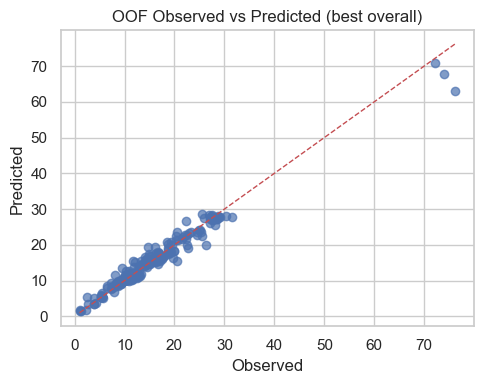

Saved: outputs/figures/holdout_obs_vs_pred_best_overall.png


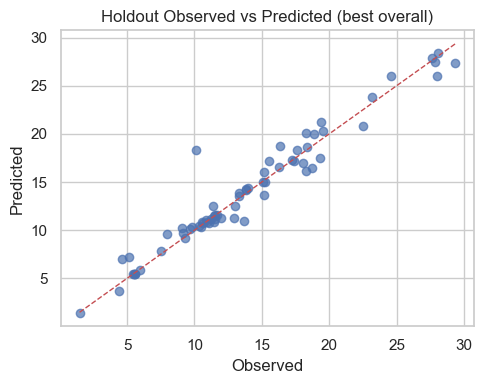

Saved: outputs/figures/holdout_residuals_vs_pred.png


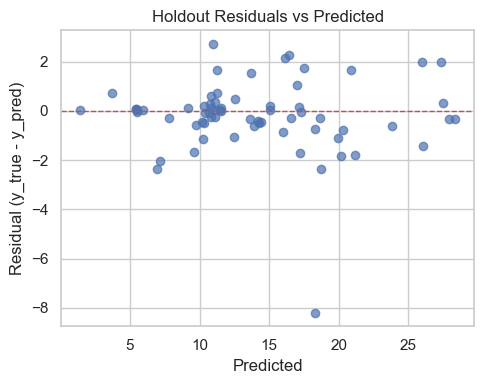

Saved: outputs/figures/holdout_residual_hist.png


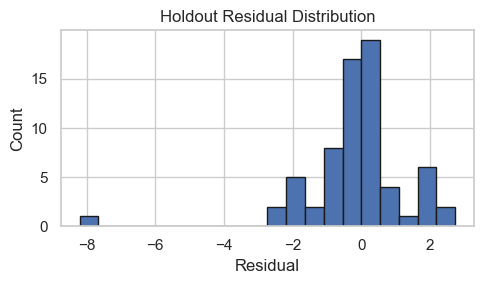

Saved: outputs/figures/holdout_mae_by_hole_shape.png


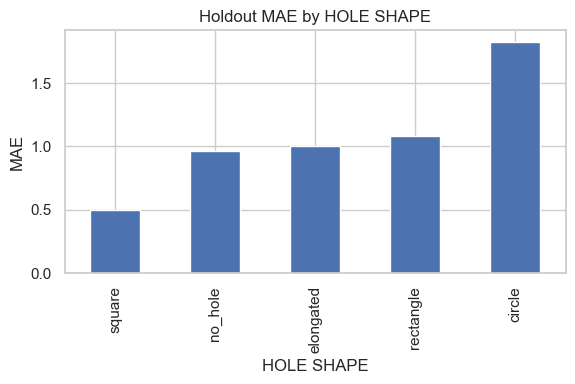

Saved: outputs/figures/holdout_mae_by_journal.png


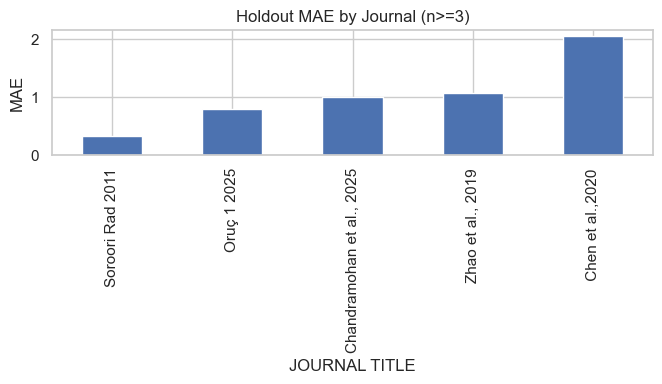

In [23]:
# Post-model plots (best overall)

# OOF: observed vs predicted
plt.figure(figsize=(5, 4))
plt.scatter(y_train, oof_pred, alpha=0.7)
mn, mx = y_train.min(), y_train.max()
plt.plot([mn, mx], [mn, mx], "r--", lw=1)
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("OOF Observed vs Predicted (best overall)")
plt.tight_layout()
savefig("oof_obs_vs_pred_best_overall")
plt.show()

# Holdout: observed vs predicted
plt.figure(figsize=(5, 4))
plt.scatter(y_test, holdout_pred, alpha=0.7)
mn, mx = y_test.min(), y_test.max()
plt.plot([mn, mx], [mn, mx], "r--", lw=1)
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Holdout Observed vs Predicted (best overall)")
plt.tight_layout()
savefig("holdout_obs_vs_pred_best_overall")
plt.show()

# Residuals vs predicted (holdout)
residuals = y_test.values - holdout_pred
plt.figure(figsize=(5, 4))
plt.scatter(holdout_pred, residuals, alpha=0.7)
plt.axhline(0, color="r", linestyle="--", lw=1)
plt.xlabel("Predicted")
plt.ylabel("Residual (y_true - y_pred)")
plt.title("Holdout Residuals vs Predicted")
plt.tight_layout()
savefig("holdout_residuals_vs_pred")
plt.show()

# Residual distribution (holdout)
plt.figure(figsize=(5, 3))
plt.hist(residuals, bins=20, edgecolor="k")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title("Holdout Residual Distribution")
plt.tight_layout()
savefig("holdout_residual_hist")
plt.show()

# MAE by HOLE SHAPE (holdout)
holdout_df = df_test.copy()
holdout_df["y_true"] = y_test.values
holdout_df["y_pred"] = holdout_pred
holdout_df["abs_error"] = (holdout_df["y_true"] - holdout_df["y_pred"]).abs()

mae_by_shape = holdout_df.groupby("HOLE SHAPE")["abs_error"].mean().sort_values()
plt.figure(figsize=(6, 4))
mae_by_shape.plot(kind="bar")
plt.ylabel("MAE")
plt.title("Holdout MAE by HOLE SHAPE")
plt.tight_layout()
savefig("holdout_mae_by_hole_shape")
plt.show()

# MAE by JOURNAL TITLE (holdout)
journal_stats = (
    holdout_df.groupby("JOURNAL TITLE")["abs_error"]
              .agg(mae="mean", n="size")
              .sort_values("mae")
)
min_journal_n = 3
journal_stats = journal_stats[journal_stats["n"] >= min_journal_n]

plt.figure(figsize=(7, 4))
journal_stats["mae"].plot(kind="bar")
plt.title(f"Holdout MAE by Journal (n>={min_journal_n})")
plt.ylabel("MAE")
plt.xticks(rotation=90)
plt.tight_layout()
savefig("holdout_mae_by_journal")
plt.show()

mae_by_shape.to_csv("outputs/tables/mae_by_hole_shape_holdout.csv")
journal_stats.to_csv("outputs/tables/mae_by_journal_holdout.csv")

Saved: outputs/figures/top_linear_coefficients.png


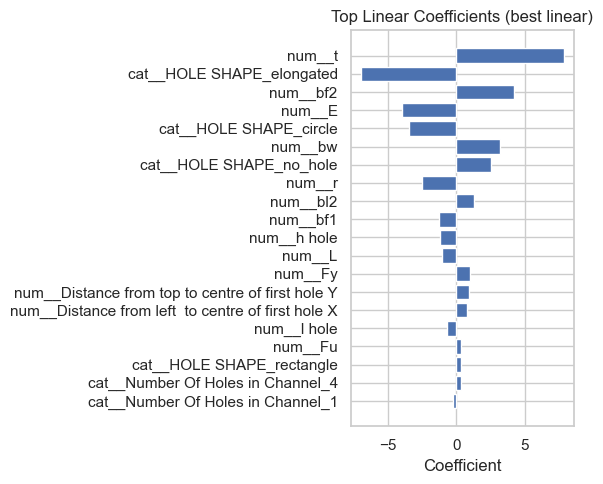

Saved: outputs/figures/top_tree_feature_importances.png


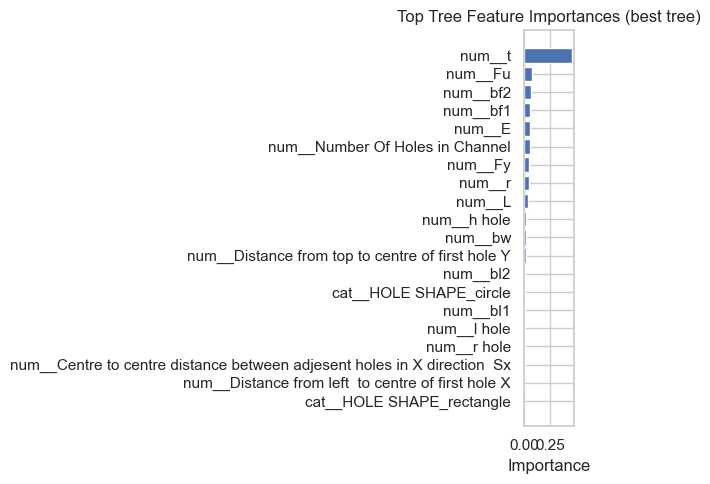

In [24]:
# Interpretability: best linear coefficients + best tree importances

def get_feature_names(preprocess):
    try:
        return preprocess.get_feature_names_out()
    except AttributeError:
        return [f"f{i}" for i in range(preprocess.transform(X_train[:1]).shape[1])]


def fit_pipeline(model_id):
    name, params_str = model_id.split("|", 1)
    params = ast.literal_eval(params_str)
    spec = spec_map[name]
    pipe = Pipeline([("prep", spec["preprocess"]), ("model", spec["estimator"])])
    pipe = pipe.set_params(**params)
    pipe.fit(X_train, y_train)
    return pipe

# Linear coefficients
best_linear_id = best_linear["model_id"]
pipe_linear = fit_pipeline(best_linear_id)
linear_feature_names = get_feature_names(pipe_linear.named_steps["prep"])
coef = pipe_linear.named_steps["model"].coef_.ravel()

coef_df = pd.DataFrame({"feature": linear_feature_names, "coef": coef})
coef_df["abs_coef"] = coef_df["coef"].abs()
top_coef = coef_df.sort_values("abs_coef", ascending=False).head(20)

plt.figure(figsize=(6, 5))
plt.barh(top_coef["feature"][::-1], top_coef["coef"][::-1])
plt.title("Top Linear Coefficients (best linear)")
plt.xlabel("Coefficient")
plt.tight_layout()
savefig("top_linear_coefficients")
plt.show()

# Tree importances
best_tree_id = best_tree["model_id"]
pipe_tree = fit_pipeline(best_tree_id)

if hasattr(pipe_tree.named_steps["model"], "feature_importances_"):
    tree_feature_names = get_feature_names(pipe_tree.named_steps["prep"])
    importances = pipe_tree.named_steps["model"].feature_importances_
    imp_df = pd.DataFrame({"feature": tree_feature_names, "importance": importances})
    top_imp = imp_df.sort_values("importance", ascending=False).head(20)

    plt.figure(figsize=(6, 5))
    plt.barh(top_imp["feature"][::-1], top_imp["importance"][::-1])
    plt.title("Top Tree Feature Importances (best tree)")
    plt.xlabel("Importance")
    plt.tight_layout()
    savefig("top_tree_feature_importances")
    plt.show()
else:
    print("Tree model has no feature_importances_ attribute.")

## Phase 10 — Final refit + save artifacts
Refit the best linear and tree models on the full aggregated dataset and save outputs.

[Full fit] Linear MAE=0.913 | Pearson=0.989
[Full fit] Tree   MAE=0.444 | Pearson=0.996
Saved: outputs/figures/full_fit_obs_vs_pred_linear.png


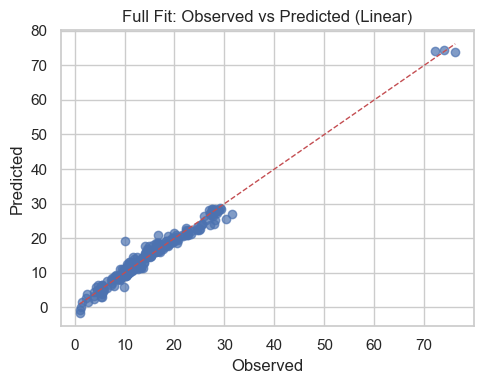

Saved: outputs/figures/full_fit_obs_vs_pred_tree.png


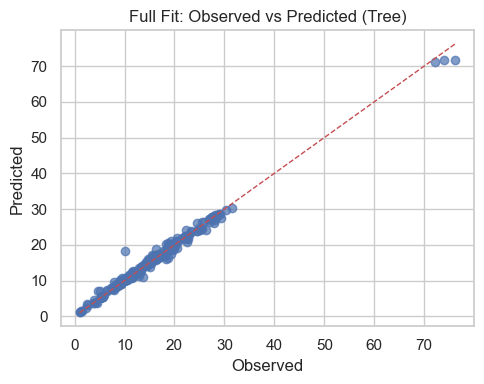

In [25]:
import joblib

# Full data
X_full = df_agg[feature_cols].copy()
y_full = df_agg["target_mean"].copy()

# Fit final models
final_linear = fit_pipeline(best_linear_id)
final_tree = fit_pipeline(best_tree_id)

# Save models
joblib.dump(final_linear, "outputs/models/best_linear_model.joblib")
joblib.dump(final_tree, "outputs/models/best_tree_model.joblib")

# Save datasets
df.to_csv("data/interim/cleaned.csv", index=False)
df_agg.to_csv("data/interim/aggregated.csv", index=False)

# Save model selection summary
selection_df = pd.DataFrame([best_linear, best_tree], index=["best_linear", "best_tree"])
selection_df.to_csv("outputs/tables/model_selection.csv", index=True)

# Full-fit diagnostics (in-sample)
from sklearn.metrics import mean_absolute_error

pred_linear_full = final_linear.predict(X_full)
pred_tree_full = final_tree.predict(X_full)

mae_linear = mean_absolute_error(y_full, pred_linear_full)
mae_tree = mean_absolute_error(y_full, pred_tree_full)

corr_linear = np.corrcoef(y_full, pred_linear_full)[0, 1]
corr_tree = np.corrcoef(y_full, pred_tree_full)[0, 1]

print(f"[Full fit] Linear MAE={mae_linear:.3f} | Pearson={corr_linear:.3f}")
print(f"[Full fit] Tree   MAE={mae_tree:.3f} | Pearson={corr_tree:.3f}")

# Plots
plt.figure(figsize=(5, 4))
plt.scatter(y_full, pred_linear_full, alpha=0.7)
mn, mx = y_full.min(), y_full.max()
plt.plot([mn, mx], [mn, mx], "r--", lw=1)
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Full Fit: Observed vs Predicted (Linear)")
plt.tight_layout()
savefig("full_fit_obs_vs_pred_linear")
plt.show()

plt.figure(figsize=(5, 4))
plt.scatter(y_full, pred_tree_full, alpha=0.7)
plt.plot([mn, mx], [mn, mx], "r--", lw=1)
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Full Fit: Observed vs Predicted (Tree)")
plt.tight_layout()
savefig("full_fit_obs_vs_pred_tree")
plt.show()

## How to run in Colab
1. Upload `data.xlsx` to Colab (`/content/data.xlsx`).
2. Set `DATA_PATH = Path("/content/data.xlsx")` in the setup cell.
3. Run the notebook top to bottom.